In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


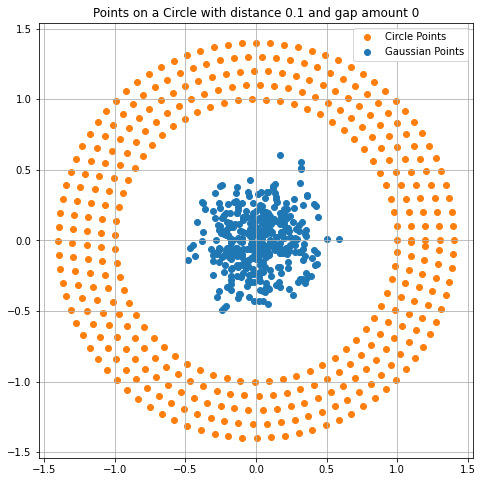

In [7]:
def generate_circle_points(radius, eps, gap_amount, dtype=torch.float32, label_type=torch.int64):
    """
    Generates points on a circle of given radius with a minimum distance between points.

    Args:
        radius (float): Radius of the circle.
        eps (float): Minimum Euclidean distance between points.
        dtype (torch.dtype): Data type for the points.
        label_type (torch.dtype): Data type for the labels.

    Returns:
        tuple: (points, labels) where points are of type dtype and labels are of type label_type.
    """
    points = []
    angle_step = 2 * np.arcsin(eps / (2 * radius))  # Approximation for minimum angle

    angle = 0.0
    while angle < 2 * np.pi - gap_amount*angle_step:
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        points.append((x, y))
        angle += angle_step

    points = torch.tensor(points, dtype=dtype)
    labels = torch.ones(points.size(0), dtype=label_type)  # Assign label 1 to all points

    return points, labels

def generate_gaussian_points(count, mean, std_dev, dtype=torch.float32, label_type=torch.int64):
    """
    Generates Gaussian-distributed points around a given mean with standard deviation.

    Args:
        count (int): Number of points to generate.
        mean (float): Mean value for Gaussian distribution.
        std_dev (float): Standard deviation for Gaussian distribution.
        dtype (torch.dtype): Data type for the points.
        label_type (torch.dtype): Data type for the labels.

    Returns:
        tuple: (points, labels) where points are of type dtype and labels are of type label_type.
    """
    points = torch.normal(mean=mean, std=std_dev, size=(count, 2), dtype=dtype)
    labels = torch.zeros(count, dtype=label_type)  # Assign label 0 to all points

    return points, labels

# Parameters for the circle
radii = [1.,1.1,1.2,1.3,1.4]
epsilon = 0.1
gap_amount = 0

# Generate the dataset for the circle
circle_points_all = torch.zeros(0, dtype=torch.float32)
circle_labels_all = torch.ones(0, dtype=torch.int64)  # Assign label 1 to all points

for radius in radii:
    circle_points, circle_labels = generate_circle_points(radius, epsilon, gap_amount = gap_amount)
    circle_points_all = torch.cat((circle_points_all, circle_points), dim=0)
    circle_labels_all = torch.cat((circle_labels_all, circle_labels), dim=0)        
    

# Generate Gaussian-distributed points
num_gaussian_points = circle_points_all.size(0)
mean = 0.0
std_dev = 0.2
gaussian_points, gaussian_labels = generate_gaussian_points(num_gaussian_points, mean, std_dev)

# Combine datasets
all_points = torch.cat((circle_points_all, gaussian_points), dim=0)
all_labels = torch.cat((circle_labels_all, gaussian_labels), dim=0)



# Plot the points
plt.figure(figsize=(8, 8))
plt.scatter(circle_points_all[:, 0].numpy(), circle_points_all[:, 1].numpy(), color='C1', label='Circle Points')
plt.scatter(gaussian_points[:, 0].numpy(), gaussian_points[:, 1].numpy(), color='C0', label='Gaussian Points')
plt.title(f'Points on a Circle with distance {epsilon} and gap amount {gap_amount}')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Define a feed-forward network with 5 layers, each of constant width 2.
class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        # Create a list of 5 linear layers (2x2 each)
        self.layers = nn.ModuleList([nn.Linear(2, 2) for _ in range(5)])
    
    def forward(self, x):
        # Apply ReLU activation for the first 4 layers; final layer outputs logits.
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x


# Training loop using a DataLoader.
def train_model(model, dataloader, epochs=100, lr=0.01):
    criterion = nn.CrossEntropyLoss()  # Suitable for binary classification (2 classes).
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Helper function to compute the matrix rank with a fallback for older PyTorch versions.
def compute_matrix_rank(matrix):
    try:
        # If available (PyTorch 1.9+), use torch.linalg.matrix_rank
        rank = torch.linalg.matrix_rank(matrix)
    except AttributeError:
        # Fallback for older PyTorch versions: compute SVD and count nonzero singular values.
        U, S, V = torch.svd(matrix)
        tol = S.max() * max(matrix.size()) * torch.finfo(S.dtype).eps
        rank = (S > tol).sum()
    return rank.item()

# Print the rank of each weight matrix in the model.
def print_weight_ranks(model):
    print("\nWeight Matrix Ranks:")
    for idx, layer in enumerate(model.layers):
        weight = layer.weight.data
        rank = compute_matrix_rank(weight)
        print(f"Layer {idx+1} weight matrix rank: {rank}")

# Main execution: training the network and printing weight ranks.
if __name__ == "__main__":
    # Set a seed for reproducibility.
    torch.manual_seed(42)
    
    model = FeedForwardNN()
    X, y = generate_data()
    train_model(model, X, y, epochs=100, lr=0.01)
    print_weight_ranks(model)
